In [1]:
import awkward as ak
import numpy as np
import os
import re
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import pandas as pd
plt.style.use("figures.mplstyle")
import sys

sys.path.append("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/")
from src.HNLimits import hnl_tools


In [2]:
# Directory containing parquet files
base_dir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/"

# Regex to extract m4 and Um4 from filename
pattern = re.compile(r"m4_(\d+)_Um4_([0-9.]+)")

# Group files by (m4, Um4)
upscatter_groups = defaultdict(list)
mesondecay_groups = defaultdict(list)

# upscatter files
for fname in glob.glob(os.path.join(base_dir, "PYTHIA*NC*.parquet")) + glob.glob(os.path.join(base_dir, "MS*NC*.parquet")):
    match = pattern.search(fname)
    if match:
        m4 = match.group(1)
        Um4 = match.group(2).rstrip('.')
        upscatter_groups[(m4, Um4)].append(os.path.abspath(fname))

# meson decay files
for fname in glob.glob(os.path.join(base_dir, "MesonDecay*seed*.parquet")):
    match = pattern.search(fname)
    if match:
        m4 = match.group(1)
        Um4 = match.group(2).rstrip('.')
        mesondecay_groups[(m4, Um4)].append(os.path.abspath(fname))

print(len(upscatter_groups))
print(len(mesondecay_groups))

720
1040


In [3]:
# Check if there are any missing simulation files

upscatter_param_files = ["hnl_params.csv","hnl_params_2.csv"]
decay_param_files = ["decay_hnl_params.csv"]

for param_file in upscatter_param_files:
    upscatter_sim_job_list = pd.read_csv(base_dir+param_file, names=["PRIMARY", "GEN", "MESON", "N", "OUTPUT", "EXPERIMENT", "XSMode", "m4", "Um4", "seed"])
    upscatter_missing = np.where([not os.path.exists(out+".parquet") for out in upscatter_sim_job_list["OUTPUT"]])
    print(len(upscatter_missing[0]))
    print("sbatch --array=", end="")
    if len(upscatter_missing[0])>500:
        indices_file = open(f"{base_dir}/missing_indices_{param_file}.txt","w")
        for i,evt in enumerate(list(upscatter_missing[0])):
            print("%d"%evt, file=indices_file)
        indices_file.close()
        print(f"0-{len(upscatter_missing[0])-1}", end="")
        print(f" --export=INDEX_FILE={base_dir}/missing_indices_{param_file}.txt,PARAMS_FILE={base_dir}{param_file} submit_hnl_simulation.sbatch")
    else:
        current_end=0
        for i,evt in enumerate(list(upscatter_missing[0])):
            if i==0:
                print("%d"%evt, end="")
                current_end = evt
                continue
            elif evt!=list(upscatter_missing[0])[i-1]+1:
                if current_end==list(upscatter_missing[0])[i-1]:
                    print(",%d"%(evt), end="")
                else:
                    print("-%d,%d"%(list(upscatter_missing[0])[i-1],evt), end="")
                current_end = evt
        print(f" --export=PARAMS_FILE={base_dir}{param_file} submit_hnl_simulation.sbatch")

for param_file in decay_param_files:
    decay_sim_job_list = pd.read_csv(base_dir+param_file, names=["N", "OUTPUT", "EXPERIMENT", "m4", "Um4", "seed"])
    decay_missing = np.where([not os.path.exists(out+".parquet") for out in decay_sim_job_list["OUTPUT"]])
    print(len(decay_missing[0]))
    print("sbatch --array=", end="")
    for evt in list(decay_missing[0]):
        print("%d,"%evt, end="")
    print(f" --export=PARAMS_FILE={base_dir}{param_file} submit_decay_hnl_simulation.sbatch")

40
sbatch --array=1457,1529,1601,1673,1745,1817,1889,1961,2033,2105,2177,2249,2321,2393,2465,2537,2609,2681,2753,2825,4337,4409,4481,4553,4625,4697,4769,4841,4913,4985,5057,5129,5201,5273,5345,5417,5489,5561,5633,5705 --export=PARAMS_FILE=/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/hnl_params.csv submit_hnl_simulation.sbatch
0
sbatch --array= --export=PARAMS_FILE=/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/hnl_params_2.csv submit_hnl_simulation.sbatch
0
sbatch --array= --export=PARAMS_FILE=/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/decay_hnl_params.csv submit_decay_hnl_simulation.sbatch


In [14]:
# generate processing cluster job lists

from curses import meta


job_list_length = 100 # number of m4,Um4 points per job
metafile = open("cluster/SIREN/hnl_job_list_metafile.txt", "w")
metafile_lines = 0
for group_dict, group_name in zip([upscatter_groups, mesondecay_groups], ["upscatter", "mesondecay"]):
    job_list = []
    if group_name=="upscatter":
        # we must account for {light,charm} and {14,-14} separately
        weight_mod_dict = {"light_14":1,"light_-14":1,"charm_14":1,"charm_-14":1}
        subfiles = {"light_14": [], "light_-14": [], "charm_14": [], "charm_-14": []}
    for i, ((m4, Um4), files) in enumerate(group_dict.items()):
        if i % job_list_length == 0 and i > 0:
            filename = f"hnl_processing_job_lists/hnl_job_list_{group_name}_{i//job_list_length}.txt"
            metafile.write(f"{group_name},{filename}\n")
            metafile_lines += 1
            with open(f"cluster/SIREN/{filename}", "w") as f:
                f.writelines(job_list)
            job_list = []
        if group_name == "upscatter":
            for meson in ["light","charm"]:
                for primary in [14,-14]:
                    subfiles[f"{meson}_{primary}"] = [f for f in files if f"{meson}_{primary}" in f]
                    weight_mod_dict[f"{meson}_{primary}"] = 1./len(subfiles[f"{meson}_{primary}"]) if len(subfiles[f"{meson}_{primary}"])>0 else 0 # each has nseeds files per (m4, Um4)
                    if weight_mod_dict[f"{meson}_{primary}"]>0:
                        job_list.append(f"{m4} {Um4} {meson}_{primary} {weight_mod_dict[f'{meson}_{primary}']} {' '.join(subfiles[f'{meson}_{primary}'])}\n")
                        subfiles[f"{meson}_{primary}"] = [] # reset for next (m4, Um4)
        elif group_name == "mesondecay":
            weight_mod = 1./len(files) # MesonDecay has nseeds files per (m4, Um4)
            job_list.append(f"{m4} {Um4} all {weight_mod} {' '.join(files)}\n")

    filename = f"hnl_processing_job_lists/hnl_job_list_{group_name}_{1+len(group_dict)//job_list_length}.txt"
    metafile.write(f"{group_name},{filename}\n")
    metafile_lines += 1
    with open(f"cluster/SIREN/{filename}", "w") as f:
        f.writelines(job_list)
metafile.close()
print("sbatch --array=0-%d --export=METAFILELIST=hnl_job_list_metafile.txt submit_hnl_process.sbatch"%(metafile_lines-1))

sbatch --array=0-18 --export=METAFILELIST=hnl_job_list_metafile.txt submit_hnl_process.sbatch


In [15]:
rate_dict = {k:{"dimuon":{}, "delayed":{}, "displaced":{}, "muon":{}} for k in ["upscatter", "mesondecay"]}
sim_dict = {k:{} for k in ["upscatter", "mesondecay"]}

In [17]:
from re import sub


for groups,group_name in zip([mesondecay_groups, upscatter_groups], ["mesondecay", "upscatter"]):
    subgroups = ["light_14", "light_-14", "charm_14", "charm_-14"] if group_name=="upscatter" else ["all"]
    print(f"Processing {group_name} groups...")
    for i,((m4, Um4), files) in enumerate(groups.items()):
        print("Processing group %d out of %d"%(i,len(groups)),end='\r')
        dimuon_total = 0.0
        delayed_total = 0.0
        displaced_total = 0.0
        muon_total = 0.0
        totals = {muon_key:0 for muon_key in rate_dict[group_name].keys()}
        for subgroup in subgroups:
            input_data = pd.read_csv(f"Data/SIREN/Output/SINE_CMS_West/HNLs/summary_files/{group_name}_{subgroup}_m4_{m4}_Um4_{Um4}_rate.txt",delim_whitespace=True)
            for muon_key in rate_dict[group_name].keys():
                totals[muon_key] += input_data[muon_key].item()
        for muon_key in rate_dict[group_name].keys():
            rate_dict[group_name][muon_key][(m4, Um4)] = totals[muon_key]

Processing mesondecay groups...
Processing upscatter groups...040


NameError: name 'full_HNL_sim' is not defined

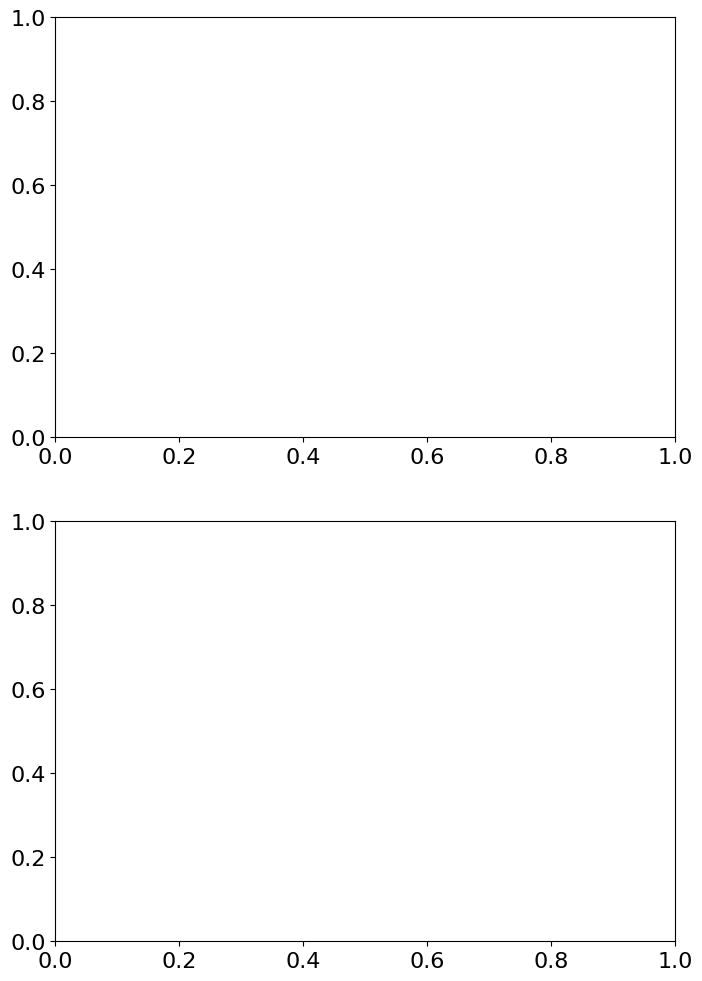

In [7]:
for Um4 in ["0.00100","0.01129","0.10000"]:
    fig,ax = plt.subplots(2,1,figsize=(8,12))
     # Create colormap
    #cmap = cm.get_cmap('viridis')  # You can use 'plasma', 'inferno', 'coolwarm', etc.
    #norm = mcolors.Normalize(vmin=float(m4_strings[0]), vmax=float(m4_strings[-1]))
    for m4 in ["1000","5000"]:
        k = (m4,Um4)
        #color = cmap(norm(float(m4)))
        #HNL_dist = np.linalg.norm(full_HNL_sim[k].vertex[:,1] - full_HNL_sim[k].vertex[:,0],axis=1)
        survival_prob = np.array(np.prod(full_HNL_sim[k].survival_probs,axis=-1))
        ax[0].hist(np.array(full_HNL_sim[k]["max_deltaT"]),
                     weights=np.array(full_HNL_sim[k]["weights"])*survival_prob,
                     bins=np.linspace(-1,20,200),
                     histtype="step",
                     label=r"$m_4=%s$ MeV (%1.2f events)"%(m4,sum(full_HNL_sim[k]["weights"])),
                     #color=color
                     )
        ax[1].hist(np.array(full_HNL_sim[k]["max_transverseDisp"]),
                   weights=np.array(full_HNL_sim[k]["weights"])*survival_prob,
                   bins=np.linspace(0,1,100),
                   histtype="step",
                   #color=color,
                   label=r"$m_4=%s$ MeV (%1.2f events)"%(m4,sum(full_HNL_sim[k]["weights"])))
    ax[0].set_xlabel(r"$t_{HNL \,{\rm signal}} - t_{\rm light}$ [ns]")
    ax[0].set_ylabel("Rate [Hz]")
    ax[0].legend(loc="upper right",fontsize=14,title=r"$|U_{m_4}|^2=%1.1e$"%(float(Um4)**2))
    ax[0].set_yscale("log")
    ax[1].set_xlabel(r"Transverse displacement [m]")
    ax[1].set_ylabel("Rate [Hz]")
    ax[1].set_yscale("log")
    plt.show()
    plt.close(fig)

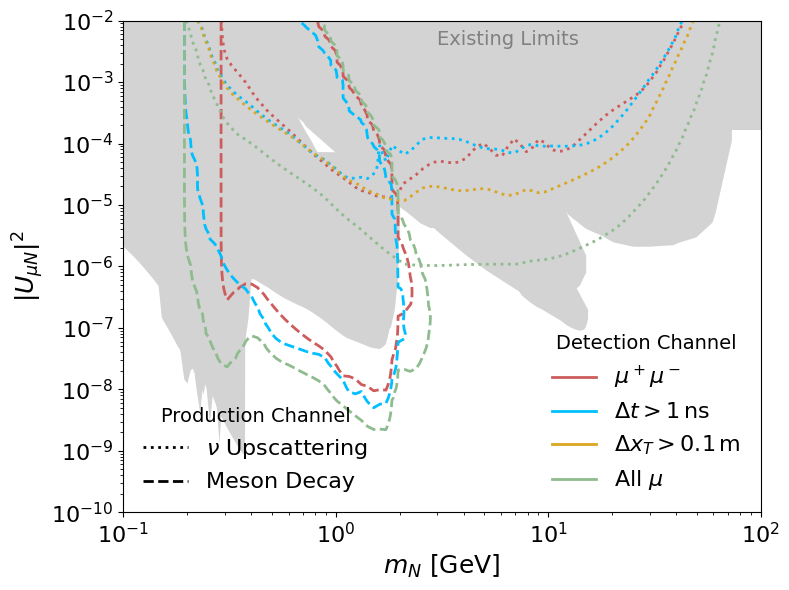

In [81]:
case_muon = hnl_tools.Limits(flavor='mu', invisible=False, nature='majorana')

from hepunits import g
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from scipy.interpolate import CloughTocher2DInterpolator

plt.figure(figsize=(8,6))
m4_min = 0.1
m4_max = 100

m4_range = np.logspace(np.log10(m4_min),np.log10(m4_max),200)

# first, plot existing limits
plt.text(3,4e-3,"Existing Limits",color="gray",fontsize=14)
for case,limit in case_muon.limits.iterrows():
    if limit.m4_top is not None and limit.plot_label!="NuTeV":
        # Create points for convex hull
        # Combine bottom and top curves
        points = np.column_stack([limit.m4,limit.ualpha4])

        # Remove any duplicate or invalid points
        points = points[~np.isnan(points).any(axis=1)]

        if len(points) > 2:
            # Compute convex hull
            hull = ConvexHull(points)

            # Create polygon from hull vertices
            hull_points = points[hull.vertices]
            polygon = patches.Polygon(hull_points, closed=True, alpha=1,
                                      facecolor='lightgray', edgecolor=None)
            plt.gca().add_patch(polygon)
    else:
        x = m4_range
        y = limit.interp_func(m4_range)
        ytop = limit.interp_func_top(m4_range)
        nan_mask = np.logical_not(np.isnan(y) | np.isnan(ytop))
        x = x[nan_mask]
        y = y[nan_mask]
        ytop = ytop[nan_mask]
        if limit.m4_top is None or np.max(np.abs(y-ytop))<1e-3:
            ytop = 1e-2*np.ones_like(ytop)
        plt.fill_between(x,y,ytop, alpha=1, facecolor='lightgray')





# next, plot our sensitivity
detection_handles = []
for muon_key in ["dimuon", "delayed", "displaced", "muon"]:

    upscatter_results = rate_dict["upscatter"][muon_key]
    mesondecay_results = rate_dict["mesondecay"][muon_key]

    if muon_key=="dimuon":
        color = "indianred"
        label=r"$\mu^+\mu^-$"
    elif muon_key=="delayed":
        color = "deepskyblue"
        label=r"$\Delta  t > 1\,{\rm ns}$"
    elif muon_key=="displaced":
        color = "goldenrod"
        label=r"$\Delta  x_T > 0.1\,{\rm m}$"
    elif muon_key=="muon":
        color = "darkseagreen"
        label=r"All $\mu$"

    rate_func = {}
    for group_name,results in zip(["upscatter", "mesondecay"], [upscatter_results, mesondecay_results]):

        # Prepare data
        m4_strs = np.unique(np.array([str(k[0]) for k in results.keys()]))
        Um4_strs = np.unique(np.array([str(k[1]) for k in results.keys()]))
        m4_sort_idx = np.argsort(np.array(m4_strs,dtype=float))
        Um4_sort_idx = np.argsort(np.array(Um4_strs,dtype=float))
        m4_strs = m4_strs[m4_sort_idx]

        Um4_strs = Um4_strs[Um4_sort_idx]
        x = np.array(m4_strs,dtype=float)/1e3 # GeV
        y = np.array(Um4_strs,dtype=float)**2
        z = []#np.zeros((len(x),len(y)))
        points = []

        for i,Um4_str in enumerate(Um4_strs):
            for j,m4_str in enumerate(m4_strs):
                k = (m4_str,Um4_str)
                #print(k)
                #print(results[k])
                if k in results.keys() and results[k]>0:
                    points.append((np.log10(float(m4_str)/1e3), np.log10(float(Um4_str)**2)))
                    z.append(np.log10(results[k]))

        # make interpolator
        rate_func[group_name] = CloughTocher2DInterpolator(points,z, fill_value=-np.inf)



    # Define grid for interpolation
    m4_grid = np.logspace(np.log10(0.1), np.log10(70), 100)
    Um4_sq_grid = np.logspace(-10, -2, 100)
    X, Y = np.meshgrid(m4_grid, Um4_sq_grid)
    mesondecay_Z = 10**rate_func["mesondecay"](np.log10(X), np.log10(Y))
    upscatter_Z = 10**rate_func["upscatter"](np.log10(X), np.log10(Y))
    Z = upscatter_Z + mesondecay_Z
    contours = plt.contour(X, Y, upscatter_Z, levels=[1],colors=[color],linestyles=[":"])
    if muon_key!="displaced": contours = plt.contour(X, Y, mesondecay_Z, levels=[1],colors=[color],linestyles=["--"])
    #contours = plt.contour(X, Y, Z, levels=[1],colors=[color],linestyles=["-"])
    detection_handles.append(plt.plot([],[], color=color, label=label)[0])

# --- Create Production Channel Legend Handles ---
production_handles = [
    plt.plot([],[],color="black",linestyle=":",label=r"$\nu$ Upscattering")[0],
    plt.plot([],[],color="black",linestyle="--",label="Meson Decay")[0],
    #plt.plot([],[],color="black",linestyle="-",label="Total")[0]
]

# --- Create and place the two legends ---
# Create the first legend (for detection channels)
legend1 = plt.legend(handles=detection_handles, loc="lower right", title="Detection Channel")
# Add the first legend to the current axes
plt.gca().add_artist(legend1)

# Create the second legend (for production channels)
plt.legend(handles=production_handles, loc="lower left", title="Production Channel")

plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$|U_{\mu N}|^2$')
plt.loglog()
plt.ylim(1e-10,1e-2)
plt.xlim(m4_min,m4_max)
plt.tight_layout()
#plt.legend(loc="lower right",ncol=2)
plt.savefig("Figures/HNL/SINE_HNL_Sensitivity.pdf",dpi=100)
plt.show()

# Cross section comparison

In [ ]:
import siren
import os

cross_section_model = "HNLDISSplines"
xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

nutype = "nu"
primary = 14
primary_type = (siren.dataclasses.Particle.ParticleType)(primary)

m4 = "0002000"
Ue4 = 0
Umu4 = 1
Utau4 = 0

HNL_DIS_xs = {}
for m4 in m4_strings:
    m4_str = f"{int(m4):07d}"
    HNL_DIS_xs[m4] = siren.interactions.HNLDISFromSpline(
        os.path.join(xsfiledir, "M_0000000MeV/dsdxdy-%s-N-nc-GRV98lo_patched_central.fits"%nutype),
        os.path.join(xsfiledir, "M_%sMeV/sigma-%s-N-nc-GRV98lo_patched_central.fits"%(m4_str,nutype)),
        float(m4)*1e-3,
        [Ue4,Umu4,Utau4],
        siren.utilities.Constants.isoscalarMass,
        1,
        [primary_type],
        [target_type],
    )

xsfiledir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/pweigel/cross_sections/20241017"
# cross_section_model = "HNLDISSplines"
# xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon
nutype = "neutrino"
nuflavor = "muon"
minQ2 = 1

DIS_xs_NC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )
DIS_xs_CC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )

/tmp/ipykernel_1874093/2807478727.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


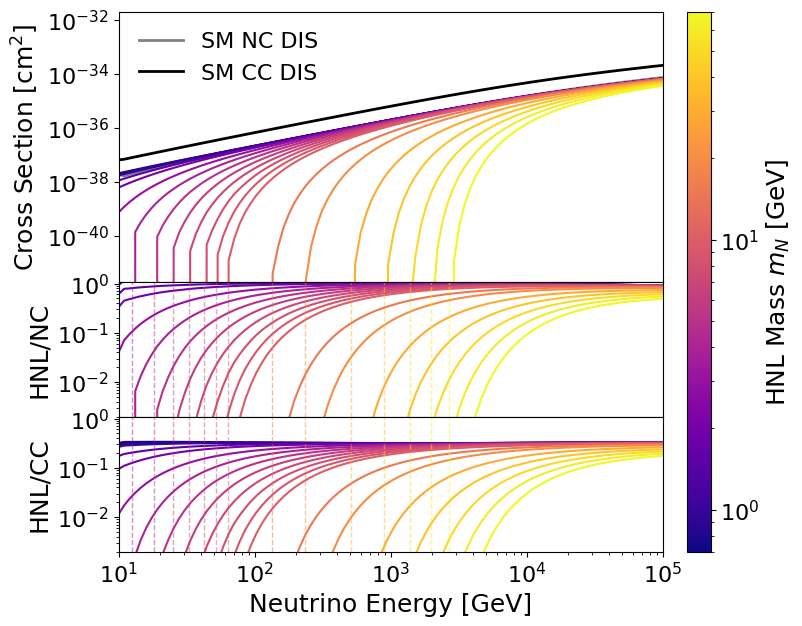

In [ ]:
import matplotlib.gridspec as gridspec

# Create a custom grid layout
fig = plt.figure()
gs = gridspec.GridSpec(3,1, height_ratios=[1, 0.5,0.5], hspace=0)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax = [ax0,ax1,ax2]

e_range = np.logspace(1,5,100) # GeV
dis_xs_vals_NC = [DIS_xs_NC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2
dis_xs_vals_CC = [DIS_xs_CC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2

ax[0].plot(e_range,dis_xs_vals_NC,label="SM NC DIS",color="gray")
ax[0].plot(e_range,dis_xs_vals_CC,label="SM CC DIS",color="black")

# Colormap for HNL mass
masses_GeV = np.array([float(m4_str)*1e-3 for m4_str in HNL_DIS_xs.keys()])
mmin, mmax = masses_GeV.min(), masses_GeV.max()
cmap = cm.get_cmap("plasma")
norm = mcolors.LogNorm(vmin=mmin, vmax=mmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot HNL curves color-coded by mass
for m4_str, hnl_xs in HNL_DIS_xs.items():
    m_geV = float(m4_str)*1e-3
    color = cmap(norm(m_geV))
    threshold = hnl_xs.InteractionThreshold(siren.dataclasses.InteractionRecord())
    hnl_xs_vals = [hnl_xs.TotalCrossSection(primary_type,E) if E > threshold else 0 for E in e_range] # cm^2
    ax[0].plot(e_range, hnl_xs_vals, color=color, lw=1.5)
    ax[1].plot(e_range, np.array(hnl_xs_vals)/np.array(dis_xs_vals_NC), color=color, lw=1.5)
    ax[2].plot(e_range, np.array(hnl_xs_vals)/np.array(dis_xs_vals_CC), color=color, lw=1.5)
    ax[1].axvline(threshold, ls="--", alpha=0.5, color=color, lw=1)
    ax[2].axvline(threshold, ls="--", alpha=0.5, color=color, lw=1)


for a in ax: a.loglog()
ax[2].set_xlabel("Neutrino Energy [GeV]")
ax[0].tick_params(bottom=False, labelbottom=False)
ax[1].tick_params(bottom=False, labelbottom=False)
ax[0].set_ylabel(r"Cross Section [cm$^2$]")
ax[1].set_ylabel(r"HNL/NC")
ax[2].set_ylabel(r"HNL/CC")
ax[0].set_xlim(e_range[0],e_range[-1])
ax[0].set_ylim(2e-42,2e-32)
ax[1].set_ylim(2e-3,1.1)
ax[2].set_ylim(2e-3,1.1)

# Adjust main panel space
fig.subplots_adjust(left=0.14, right=0.82, top=0.98, bottom=0.08)

# Add colorbar axis (x0,y0,width,height)
cax = fig.add_axes([0.85, 0.08, 0.03, 0.9])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r"HNL Mass $m_N$ [GeV]")

ax[0].legend()

#plt.tight_layout()
plt.savefig("Figures/HNL/SIREN_HNL_CrossSections.pdf",dpi=100,bbox_inches='tight', pad_inches=0.08)
plt.show()

# Sandbox 

In [76]:
input_files = glob.glob(os.path.join(base_dir, "summary_files/mesondecay_all_m4_1000_Um4_0.0001*parquet")) + \
              glob.glob(os.path.join(base_dir, "summary_files/mesondecay_all_m4_1000_Um4_0.0004*parquet")) + \
              glob.glob(os.path.join(base_dir, "summary_files/mesondecay_all_m4_1000_Um4_0.0005*parquet"))
data = {}
for file in input_files:
    match = pattern.search(file)
    if match:
        m4 = match.group(1)
        Um4 = match.group(2).rstrip('.')
        try:

            data[(m4, Um4)] = ak.from_parquet(os.path.abspath(file))
        except Exception as e:
            print(f"Error reading {file}: {e}")

In [77]:
data.keys()

dict_keys([('1000', '0.000170'), ('1000', '0.000134'), ('1000', '0.000106'), ('1000', '0.000438'), ('1000', '0.000554')])

210734
['event_weight', 'event_gen_time', 'event_weight_time', 'event_global_time', 'num_interactions', 'vertex', 'primary_initial_position', 'in_fiducial', 'primary_type', 'target_type', 'num_secondaries', 'secondary_types', 'primary_momentum', 'secondary_momenta', 'parent_idx', 'num_daughters', 'int_probs', 'survival_probs', 'PDG', 'hPDG', 'thx', 'thy', 'wgt', 'weights', 'muon0_panel1_int_locations', 'muon0_panel1_int_distances', 'muon0_panel1_int_coldepths', 'muon0_panel1_hit_mask', 'muon0_panel2_int_locations', 'muon0_panel2_int_distances', 'muon0_panel2_int_coldepths', 'muon0_panel2_hit_mask', 'muon0_panel3_int_locations', 'muon0_panel3_int_distances', 'muon0_panel3_int_coldepths', 'muon0_panel3_hit_mask', 'muon0_hit_mask', 'muon0_max_col_depth', 'muon0_panel1_survival', 'muon0_panel1_hit_mask_survival', 'muon0_panel2_survival', 'muon0_panel2_hit_mask_survival', 'muon0_panel3_survival', 'muon0_panel3_hit_mask_survival', 'muon0_hit_mask_survival', 'muon1_panel1_int_locations', 'muo

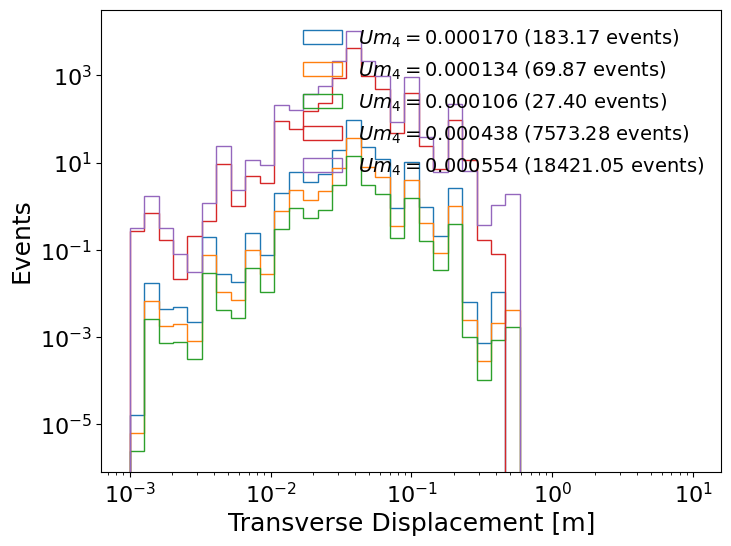

In [78]:
# make a color gradient based on Um4

for k,x in data.items():
    print(len(x))
    print(x.fields)
    print(x.max_transverseDisp)
    plt.hist(np.array(x.max_transverseDisp),
             weights=np.array(x.weights),
             bins=np.logspace(-3,1,40),
             histtype="step",
             label=r"$Um_4=%s$ (%1.2f events)"%(k[1],sum(x.weights)))
plt.loglog()
plt.xlabel(r"Transverse Displacement [m]")
plt.ylabel("Events")
plt.legend(loc="upper right",fontsize=14)
#plt.ylim(1)
plt.show()

In [ ]:
x = pd.read_csv("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Input/HNL-mu_m_0500_CMS_West.txt")

112254899.71733284
9715050.832478328


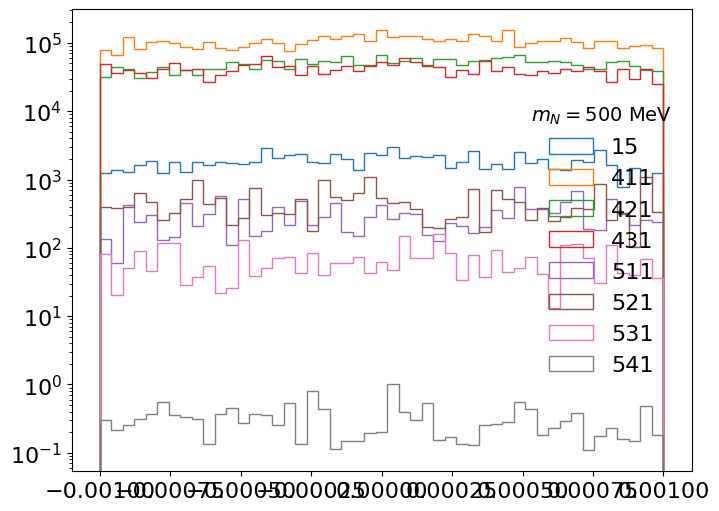

93237991.94200999
8788022.382673258


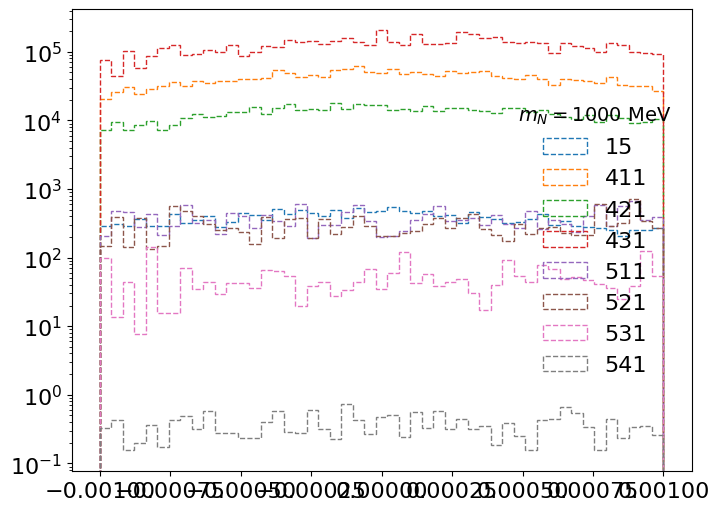

969.4925355789782
31.260276494777788


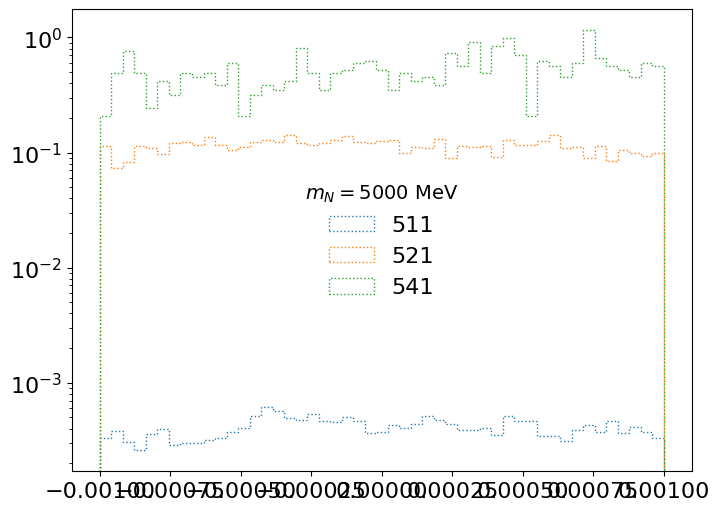

In [ ]:
for mass,linestyle in zip(["0500","1000","5000"],["-","--",":"]):
    x = pd.read_csv("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Input/HNL-mu_m_%s_CMS_West.txt" % mass)
    print(sum(x.wgt))
    x.query("abs(thx)<0.001 & abs(thy)<0.001",inplace=True)
    print(sum(x.wgt))
    hpdgs = np.unique(np.abs(x.hPDG))
    for hpdg in hpdgs:
        plt.hist(x.thy[np.abs(x.hPDG)==hpdg],bins=np.linspace(-0.001,0.001,50),histtype="step",label=int(hpdg),weights=x.wgt[np.abs(x.hPDG)==hpdg],linestyle=linestyle)
    plt.semilogy()
    plt.legend(title=r"$m_N=%d$ MeV" % int(mass))
    plt.show()

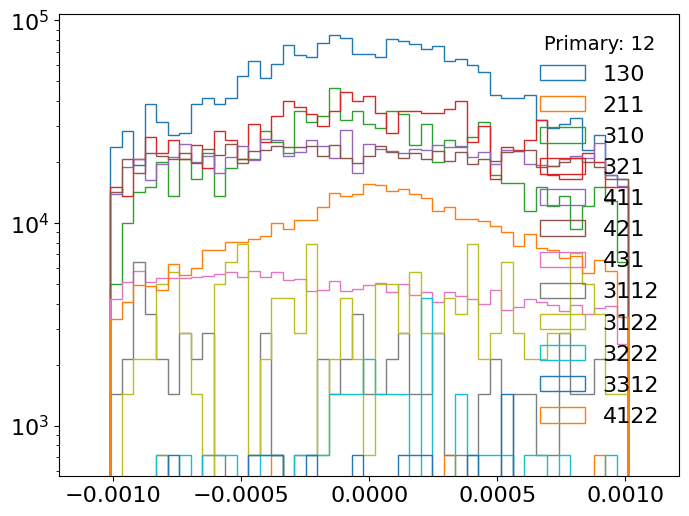

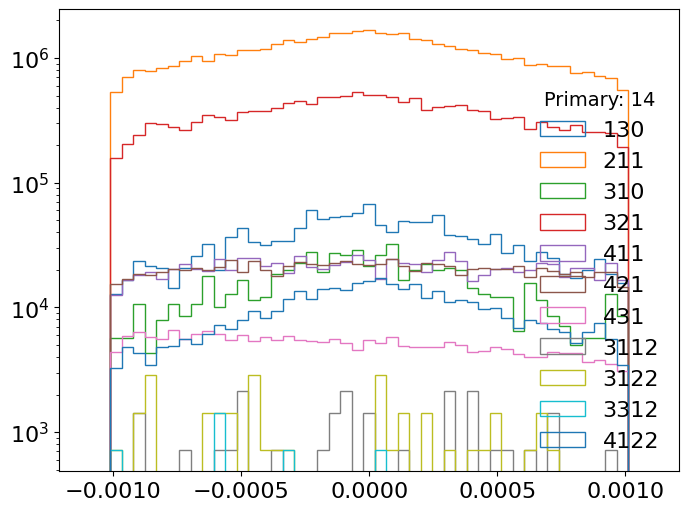

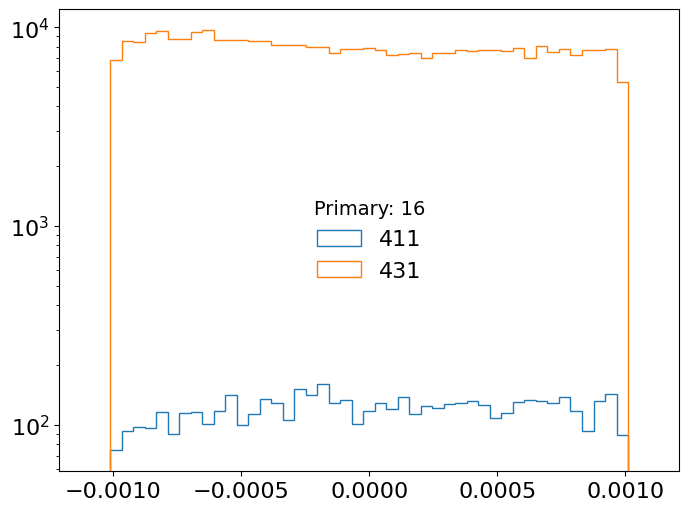

In [ ]:
for primary in [12,14,16]:
    charm = pd.read_csv("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Input/LHC13_SIBYLL_charm_%d_CMS_West.txt"%primary)
    if primary!=16:
        light = pd.read_csv("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Input/LHC13_SIBYLL_light_%d_CMS_West.txt"%primary)
        x = pd.concat([light,charm])
    else:
        x = charm
    x.query("abs(thx)<0.001 & abs(thy)<0.001",inplace=True)
    hpdgs = np.unique(np.abs(x.hPDG))
    for hpdg in hpdgs:
        plt.hist(x.thx[np.abs(x.hPDG)==hpdg],bins=np.linspace(-0.0011,0.0011,50),histtype="step",label=int(hpdg),weights=x.wgt[np.abs(x.hPDG)==hpdg])
    plt.semilogy()
    plt.legend(title=r"Primary: %d"%primary)
    plt.show()

In [ ]:
x